## XML to info_dict

In [90]:
import xml.etree.ElementTree as ET

# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

## Info dict to YOLO txt file

In [98]:
# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join(f'./all_border_dataset_2000_annotations_split/{split}', info_dict["filename"].replace("jpg", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))
    print(save_file_name)


In [99]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"border": 0}

## Get filenames

In [100]:
import os

splits = sorted(os.listdir('./all_border_dataset_2000_annotations_split'), reverse=True)
splits

['val', 'train', 'test', 'experiment']

In [101]:
split = 'experiment'
files = sorted(os.listdir(f'./all_border_dataset_2000_annotations_split/{split}'), reverse=True)
len(files)

239

In [102]:
annotated_files = [f'./all_border_dataset_2000_annotations_split/{split}/{f[:-4]}' for f in files if f[-4:] == '.xml']
len(annotated_files)

19

In [103]:
info_dict = extract_info_from_xml(f'{annotated_files[0]}.xml')

In [104]:
info_dict

{'bboxes': [{'class': 'border', 'xmin': 0, 'ymin': 0, 'xmax': 33, 'ymax': 19},
  {'class': 'border', 'xmin': 372, 'ymin': 0, 'xmax': 400, 'ymax': 16}],
 'filename': 'border_Img_000354.jpg',
 'image_size': (400, 514, 3)}

In [105]:
convert_to_yolov5(info_dict)

./all_border_dataset_2000_annotations_split/experiment/border_Img_000354.txt


In [106]:
for split in splits:
    files = sorted(os.listdir(f'./all_border_dataset_2000_annotations_split/{split}'), reverse=True)
    annotated_files = [f'./all_border_dataset_2000_annotations_split/{split}/{f[:-4]}' for f in files if f[-4:] == '.xml']
    
    for annotated_file in annotated_files:
        info_dict = extract_info_from_xml(f'{annotated_file}.xml')
        convert_to_yolov5(info_dict)

./all_border_dataset_2000_annotations_split/val/border_Img_000529.txt
./all_border_dataset_2000_annotations_split/val/border_Img_000528.txt
./all_border_dataset_2000_annotations_split/val/border_Img_000525.txt
./all_border_dataset_2000_annotations_split/val/border_Img_000520.txt
./all_border_dataset_2000_annotations_split/val/border_Img_000515.txt
./all_border_dataset_2000_annotations_split/val/border_Img_000496.txt
./all_border_dataset_2000_annotations_split/val/border_Img_000492.txt
./all_border_dataset_2000_annotations_split/val/border_Img_000468.txt
./all_border_dataset_2000_annotations_split/val/border_Img_000446.txt
./all_border_dataset_2000_annotations_split/val/border_Img_000422.txt
./all_border_dataset_2000_annotations_split/val/border_Img_000420.txt
./all_border_dataset_2000_annotations_split/val/border_Img_000419.txt
./all_border_dataset_2000_annotations_split/val/border_Img_000410.txt
./all_border_dataset_2000_annotations_split/val/border_Img_000395.txt
./all_border_dataset

## Sanity check

[[0.0, 0.041, 0.018, 0.083, 0.037], [0.0, 0.965, 0.016, 0.07, 0.031]]
[ 0.    -0.2   -0.257 33.    18.761]
[0.0000e+00 3.7200e+02 2.5700e-01 4.0000e+02 1.6191e+01]


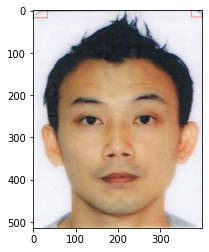

In [78]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        print(ann)
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)), outline ="red")
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = f'{annotated_files[0]}.txt'
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("txt", "jpg")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

print(annotation_list)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)